# PMEmo Dataset - Feed Forward Neural Network
## Essentia Best Overall Mean Featureset

## Import relevant libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics import R2Score

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import math

import sys
sys.path.insert(1, '../../utils')
from paths import *

## Neural Network Training

### Import annotations dataset

In [2]:
df_annotations = pd.read_csv(get_pmemo_path('processed/annotations/pmemo_static_annotations.csv'))
df_annotations

,song_id,valence_mean_mapped,arousal_mean_mapped
0,1,0.150,-0.200
1,4,-0.425,-0.475
2,5,-0.600,-0.700
3,6,-0.300,0.025
4,7,0.450,0.400
...,...,...,...
762,993,0.525,0.725
763,996,0.125,0.750
764,997,0.325,0.425
765,999,0.550,0.750


### Import the featureset

This is where you should change between normalised and standardised, and untouched featuresets!

In [3]:
df_essentia_best_overall_features_mean = pd.read_csv(get_pmemo_path('processed/features/standardised_essentia_best_overall_features_mean.csv'))

# drop Unnamed:0 column
df_essentia_best_overall_features_mean = df_essentia_best_overall_features_mean[df_essentia_best_overall_features_mean.columns[1:]]

df_essentia_best_overall_features_mean

,song_id,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_skewness.mean,lowlevel.spectral_energy.mean,tonal.chords_strength.mean,tonal.hpcp_entropy.mean,tonal.key_edma.strength,tonal.key_temperley.strength,rhythm.beats_loudness_band_ratio.mean_0,rhythm.beats_loudness_band_ratio.mean_1,...,tonal.chords_histogram_14,tonal.chords_histogram_15,tonal.chords_histogram_16,tonal.chords_histogram_17,tonal.chords_histogram_18,tonal.chords_histogram_19,tonal.chords_histogram_20,tonal.chords_histogram_21,tonal.chords_histogram_22,tonal.chords_histogram_23
0,1,-0.290830,-0.161553,-0.674310,-0.966508,-0.692188,-0.466809,-0.224314,-0.490847,-0.744314,...,-0.196902,-0.312361,-0.251295,-0.456893,-0.278709,0.345904,-0.285526,1.021745,-0.039876,0.671714
1,4,2.148017,2.355089,6.176068,-0.692793,-0.875022,-2.504826,-2.346037,1.052759,-0.515532,...,0.004772,0.540440,4.181020,-0.456893,-0.005882,0.576715,-0.285526,0.213223,-0.846705,-0.053671
2,5,4.061978,3.102229,2.654601,0.480322,0.431641,0.529917,0.178117,1.201395,-0.649196,...,-0.196902,-0.312361,-0.251295,-0.456893,-0.278709,-0.305337,-0.203477,-0.535816,-0.846705,-0.907128
3,6,0.609811,1.478902,0.594623,-0.265029,-1.486659,-1.304917,-1.560061,1.129215,-0.547660,...,-0.196902,0.386979,-0.251295,-0.456893,-0.278709,-0.374009,-0.285526,-0.179551,-0.846705,-0.907128
4,7,-0.407720,-0.322652,-0.043632,0.343143,1.010394,0.710881,0.859542,1.536379,-0.715476,...,-0.196902,-0.312361,-0.251295,-0.456893,-0.278709,-0.374009,-0.285526,0.457974,0.503538,-0.375831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,993,-0.341976,-0.376271,-0.184984,1.148765,0.172968,-0.030536,0.217640,-0.104210,1.736366,...,-0.196902,-0.312361,-0.251295,-0.129750,-0.278709,-0.374009,-0.285526,-0.443708,0.429159,3.825664
763,996,0.208018,-0.004852,-0.227602,1.123782,0.880366,0.113897,0.233136,-1.932951,1.310770,...,-0.196902,-0.312361,-0.251295,-0.456893,-0.278709,-0.374009,-0.285526,-0.535816,-0.483101,-0.814508
764,997,-0.448361,-0.267697,-0.099497,-1.869459,0.089641,-0.349415,-0.176068,-0.148750,-0.310712,...,-0.099370,-0.027929,-0.251295,0.099811,-0.278709,-0.150331,-0.285526,0.505638,-0.557852,-0.088299
765,999,-0.296933,0.022632,0.258205,-1.921844,-0.625854,-0.779872,-0.526150,0.666036,-1.240647,...,-0.196902,-0.312361,-0.251295,-0.456893,-0.229701,-0.374009,0.288011,-0.535816,0.072929,-0.798329


In [4]:
df_essentia_best_overall_features_mean.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 38 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   song_id                                  767 non-null    int64  
 1   lowlevel.melbands_kurtosis.mean          767 non-null    float64
 2   lowlevel.melbands_skewness.mean          767 non-null    float64
 3   lowlevel.spectral_energy.mean            767 non-null    float64
 4   tonal.chords_strength.mean               767 non-null    float64
 5   tonal.hpcp_entropy.mean                  767 non-null    float64
 6   tonal.key_edma.strength                  767 non-null    float64
 7   tonal.key_temperley.strength             767 non-null    float64
 8   rhythm.beats_loudness_band_ratio.mean_0  767 non-null    float64
 9   rhythm.beats_loudness_band_ratio.mean_1  767 non-null    float64
 10  rhythm.beats_loudness_band_ratio.mean_2  767 non-n

Join both the featureset and annotation set together

In [5]:
df_essentia_best_overall_features_mean_whole = pd.merge(df_essentia_best_overall_features_mean, df_annotations, how='inner', on='song_id')
df_essentia_best_overall_features_mean_whole = df_essentia_best_overall_features_mean_whole.drop('song_id', axis=1)
df_essentia_best_overall_features_mean_whole

,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_skewness.mean,lowlevel.spectral_energy.mean,tonal.chords_strength.mean,tonal.hpcp_entropy.mean,tonal.key_edma.strength,tonal.key_temperley.strength,rhythm.beats_loudness_band_ratio.mean_0,rhythm.beats_loudness_band_ratio.mean_1,rhythm.beats_loudness_band_ratio.mean_2,...,tonal.chords_histogram_16,tonal.chords_histogram_17,tonal.chords_histogram_18,tonal.chords_histogram_19,tonal.chords_histogram_20,tonal.chords_histogram_21,tonal.chords_histogram_22,tonal.chords_histogram_23,valence_mean_mapped,arousal_mean_mapped
0,-0.290830,-0.161553,-0.674310,-0.966508,-0.692188,-0.466809,-0.224314,-0.490847,-0.744314,0.149480,...,-0.251295,-0.456893,-0.278709,0.345904,-0.285526,1.021745,-0.039876,0.671714,0.150,-0.200
1,2.148017,2.355089,6.176068,-0.692793,-0.875022,-2.504826,-2.346037,1.052759,-0.515532,-0.154840,...,4.181020,-0.456893,-0.005882,0.576715,-0.285526,0.213223,-0.846705,-0.053671,-0.425,-0.475
2,4.061978,3.102229,2.654601,0.480322,0.431641,0.529917,0.178117,1.201395,-0.649196,-1.032420,...,-0.251295,-0.456893,-0.278709,-0.305337,-0.203477,-0.535816,-0.846705,-0.907128,-0.600,-0.700
3,0.609811,1.478902,0.594623,-0.265029,-1.486659,-1.304917,-1.560061,1.129215,-0.547660,-1.166668,...,-0.251295,-0.456893,-0.278709,-0.374009,-0.285526,-0.179551,-0.846705,-0.907128,-0.300,0.025
4,-0.407720,-0.322652,-0.043632,0.343143,1.010394,0.710881,0.859542,1.536379,-0.715476,-1.128256,...,-0.251295,-0.456893,-0.278709,-0.374009,-0.285526,0.457974,0.503538,-0.375831,0.450,0.400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,-0.341976,-0.376271,-0.184984,1.148765,0.172968,-0.030536,0.217640,-0.104210,1.736366,-0.502120,...,-0.251295,-0.129750,-0.278709,-0.374009,-0.285526,-0.443708,0.429159,3.825664,0.525,0.725
763,0.208018,-0.004852,-0.227602,1.123782,0.880366,0.113897,0.233136,-1.932951,1.310770,-0.198898,...,-0.251295,-0.456893,-0.278709,-0.374009,-0.285526,-0.535816,-0.483101,-0.814508,0.125,0.750
764,-0.448361,-0.267697,-0.099497,-1.869459,0.089641,-0.349415,-0.176068,-0.148750,-0.310712,-0.747041,...,-0.251295,0.099811,-0.278709,-0.150331,-0.285526,0.505638,-0.557852,-0.088299,0.325,0.425
765,-0.296933,0.022632,0.258205,-1.921844,-0.625854,-0.779872,-0.526150,0.666036,-1.240647,-1.225680,...,-0.251295,-0.456893,-0.229701,-0.374009,0.288011,-0.535816,0.072929,-0.798329,0.550,0.750


#### Prepare dataframes for the neural network

Perform splitting of the dataframe into training and testing sets

In [6]:
features = df_essentia_best_overall_features_mean.drop('song_id', axis=1)
features

,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_skewness.mean,lowlevel.spectral_energy.mean,tonal.chords_strength.mean,tonal.hpcp_entropy.mean,tonal.key_edma.strength,tonal.key_temperley.strength,rhythm.beats_loudness_band_ratio.mean_0,rhythm.beats_loudness_band_ratio.mean_1,rhythm.beats_loudness_band_ratio.mean_2,...,tonal.chords_histogram_14,tonal.chords_histogram_15,tonal.chords_histogram_16,tonal.chords_histogram_17,tonal.chords_histogram_18,tonal.chords_histogram_19,tonal.chords_histogram_20,tonal.chords_histogram_21,tonal.chords_histogram_22,tonal.chords_histogram_23
0,-0.290830,-0.161553,-0.674310,-0.966508,-0.692188,-0.466809,-0.224314,-0.490847,-0.744314,0.149480,...,-0.196902,-0.312361,-0.251295,-0.456893,-0.278709,0.345904,-0.285526,1.021745,-0.039876,0.671714
1,2.148017,2.355089,6.176068,-0.692793,-0.875022,-2.504826,-2.346037,1.052759,-0.515532,-0.154840,...,0.004772,0.540440,4.181020,-0.456893,-0.005882,0.576715,-0.285526,0.213223,-0.846705,-0.053671
2,4.061978,3.102229,2.654601,0.480322,0.431641,0.529917,0.178117,1.201395,-0.649196,-1.032420,...,-0.196902,-0.312361,-0.251295,-0.456893,-0.278709,-0.305337,-0.203477,-0.535816,-0.846705,-0.907128
3,0.609811,1.478902,0.594623,-0.265029,-1.486659,-1.304917,-1.560061,1.129215,-0.547660,-1.166668,...,-0.196902,0.386979,-0.251295,-0.456893,-0.278709,-0.374009,-0.285526,-0.179551,-0.846705,-0.907128
4,-0.407720,-0.322652,-0.043632,0.343143,1.010394,0.710881,0.859542,1.536379,-0.715476,-1.128256,...,-0.196902,-0.312361,-0.251295,-0.456893,-0.278709,-0.374009,-0.285526,0.457974,0.503538,-0.375831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,-0.341976,-0.376271,-0.184984,1.148765,0.172968,-0.030536,0.217640,-0.104210,1.736366,-0.502120,...,-0.196902,-0.312361,-0.251295,-0.129750,-0.278709,-0.374009,-0.285526,-0.443708,0.429159,3.825664
763,0.208018,-0.004852,-0.227602,1.123782,0.880366,0.113897,0.233136,-1.932951,1.310770,-0.198898,...,-0.196902,-0.312361,-0.251295,-0.456893,-0.278709,-0.374009,-0.285526,-0.535816,-0.483101,-0.814508
764,-0.448361,-0.267697,-0.099497,-1.869459,0.089641,-0.349415,-0.176068,-0.148750,-0.310712,-0.747041,...,-0.099370,-0.027929,-0.251295,0.099811,-0.278709,-0.150331,-0.285526,0.505638,-0.557852,-0.088299
765,-0.296933,0.022632,0.258205,-1.921844,-0.625854,-0.779872,-0.526150,0.666036,-1.240647,-1.225680,...,-0.196902,-0.312361,-0.251295,-0.456893,-0.229701,-0.374009,0.288011,-0.535816,0.072929,-0.798329


In [7]:
targets = df_annotations.drop('song_id', axis=1)
targets

,valence_mean_mapped,arousal_mean_mapped
0,0.150,-0.200
1,-0.425,-0.475
2,-0.600,-0.700
3,-0.300,0.025
4,0.450,0.400
...,...,...
762,0.525,0.725
763,0.125,0.750
764,0.325,0.425
765,0.550,0.750


Perform 80-20 train-test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

Create tensors for X_train and X_test

In [9]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float64)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float64)

Create tensors for Y_train and Y_test

In [10]:
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float64)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float64)

Define neural network parameters and instantitate neural network

In [11]:
input_size = 1
hidden_size = 20 
output_size = 2  # Output size for valence and arousal
learning_rate = 0.001
criterion = nn.MSELoss()

In [36]:
num_epochs = 190

Set a random seed to ensure consistent initial weights of the neural network

In [37]:
# Set the seed
seed = 42
torch.manual_seed(seed)

Define the neural network

In [38]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), 2)
        )

    def forward(self, x):
        return self.layers(x)

#### Training

Prepare input_train_data and target_train_labels

In [39]:
input_train_data = X_train_tensor.float()

# input_train_data = input_train_data.view(input_train_data.shape[1], -1)
print(input_train_data.shape)

target_train_labels = y_train_tensor

torch.Size([613, 37])


Training loop

In [40]:
def train_model(num_epochs):
  model = NeuralNetwork(input_size=input_train_data.shape[1])
  optimiser = optim.Adam(model.parameters(), lr=learning_rate)
  
  for epoch in range(num_epochs):
    optimiser.zero_grad()
    
    # forward pass
    output = model(input_train_data)

    # calculate loss
    loss = torch.sqrt(criterion(output.float(), target_train_labels.float()))

    # backward pass
    loss.backward()
    # update weights
    optimiser.step()

    print(f'Epoch {epoch + 1}, Loss: {math.sqrt(loss.item())}')

  print("Training completed.")
  return model

In [41]:
model = train_model(num_epochs)

Epoch 1, Loss: 0.6246373077883901
Epoch 2, Loss: 0.6235530315994445
Epoch 3, Loss: 0.6224941564385242
Epoch 4, Loss: 0.6214607402112515
Epoch 5, Loss: 0.6204527900466451
Epoch 6, Loss: 0.6194694440108736
Epoch 7, Loss: 0.6185101689710817
Epoch 8, Loss: 0.6175741360829309
Epoch 9, Loss: 0.6166603154637212
Epoch 10, Loss: 0.6157677896340541
Epoch 11, Loss: 0.6148956819775698
Epoch 12, Loss: 0.6140432058705364
Epoch 13, Loss: 0.6133933724123385
Epoch 14, Loss: 0.6129507644352314
Epoch 15, Loss: 0.612507350060095
Epoch 16, Loss: 0.6120650265031023
Epoch 17, Loss: 0.6116250386568451
Epoch 18, Loss: 0.6111883424112772
Epoch 19, Loss: 0.6107556279688645
Epoch 20, Loss: 0.6103272944394164
Epoch 21, Loss: 0.6099035953730362
Epoch 22, Loss: 0.6094845893326112
Epoch 23, Loss: 0.6090703349345943
Epoch 24, Loss: 0.6086606705077068
Epoch 25, Loss: 0.6082555073333157
Epoch 26, Loss: 0.6078545602401318
Epoch 27, Loss: 0.6074575677424636
Epoch 28, Loss: 0.6070642921360818
Epoch 29, Loss: 0.606674445904

## Neural Network Testing

Prepare input_test_data and target_test_labels

In [42]:
input_test_data = X_test_tensor.float()

# input_test_data = input_test_data.view(input_test_data.shape[1], -1)
print(input_test_data.shape)

target_test_labels = y_test_tensor

torch.Size([154, 37])


Generating scores

In [43]:
def test_model(trained_model):
  with torch.no_grad():
    test_pred = trained_model(input_test_data)
    test_loss = criterion(test_pred.float(), target_test_labels)

    # Separate the output into valence and arousal
    valence_pred = test_pred[:, 0]
    arousal_pred = test_pred[:, 1]
        
    valence_target = target_test_labels[:, 0]
    arousal_target = target_test_labels[:, 1]

     # Calculate RMSE for valence and arousal separately
    valence_rmse = math.sqrt(mean_squared_error(valence_pred, valence_target))
    arousal_rmse = math.sqrt(mean_squared_error(arousal_pred, arousal_target))

  rmse = math.sqrt(test_loss.item())
  print(f'Test RMSE: {rmse}')

  print(f'Valence RMSE: {valence_rmse}')
  print(f'Arousal RMSE: {arousal_rmse}')

  metric = R2Score(multioutput="raw_values")
  metric.update(test_pred, target_test_labels)
  adjusted_r2_score = metric.compute()
  print(f'Test R^2 score: {adjusted_r2_score}')

  metric = R2Score(multioutput="raw_values", num_regressors=input_test_data.shape[1])
  metric.update(test_pred, target_test_labels)
  adjusted_r2_score = metric.compute()
  print(f'Test Adjusted R^2 score: {adjusted_r2_score}')

  metric = R2Score()
  metric.update(test_pred, target_test_labels)
  r2_score = metric.compute()
  print(f'Test R^2 score (overall): {r2_score}')
  return test_pred, rmse, adjusted_r2_score, r2_score

In [44]:
test_pred, rmse, adjusted_r2_score, r2_score = test_model(model)

Test RMSE: 0.2848615667519758
Valence RMSE: 0.2623395437817343
Arousal RMSE: 0.30572894562532393
Test R^2 score: tensor([0.2646, 0.3107], dtype=torch.float64)
Test Adjusted R^2 score: tensor([0.0300, 0.0908], dtype=torch.float64)
Test R^2 score (overall): 0.2876154151963989


In [45]:
torch.save(model.state_dict(), '../../models/pmemo_feedforward_nn_essentia_best_overall_mean_standardised.pt')

True values (test set)

In [22]:
target_test_labels

tensor([[-0.5750,  0.3500],
        [ 0.1250, -0.0250],
        [ 0.2000,  0.4750],
        [ 0.3500,  0.3500],
        [ 0.3000,  0.4500],
        [ 0.3500,  0.0250],
        [ 0.3250, -0.0250],
        [ 0.3750,  0.3500],
        [ 0.1500,  0.1000],
        [ 0.2750,  0.6500],
        [ 0.5000,  0.5250],
        [ 0.0500, -0.3500],
        [ 0.0500,  0.2250],
        [-0.3250, -0.4500],
        [-0.1000,  0.4500],
        [ 0.1250, -0.4000],
        [ 0.3750,  0.5500],
        [ 0.2000, -0.2250],
        [-0.4500, -0.3000],
        [ 0.0500,  0.0750],
        [ 0.2750,  0.4250],
        [-0.0250,  0.4000],
        [ 0.6500,  0.6750],
        [-0.1750, -0.3250],
        [-0.6500,  0.6500],
        [ 0.0250,  0.3000],
        [-0.0500,  0.6750],
        [-0.7250, -0.4500],
        [ 0.0000, -0.2750],
        [ 0.2750,  0.4500],
        [ 0.0000, -0.2000],
        [ 0.3250,  0.2250],
        [-0.3750, -0.1250],
        [-0.1000,  0.2250],
        [ 0.4000,  0.2250],
        [ 0.3500,  0

Predicted values

In [23]:
test_pred

tensor([[-0.0145,  0.0497],
        [ 0.0234,  0.0909],
        [ 0.3669,  0.4695],
        [ 0.1324,  0.2085],
        [ 0.4221,  0.5350],
        [-0.0135,  0.0494],
        [ 0.0444,  0.1136],
        [ 0.3839,  0.4897],
        [-0.0137,  0.0494],
        [ 0.0813,  0.1533],
        [ 0.1903,  0.2710],
        [-0.0095,  0.0482],
        [-0.0090,  0.0481],
        [-0.0134,  0.0493],
        [ 0.3253,  0.4202],
        [ 0.1922,  0.2731],
        [ 0.3995,  0.5082],
        [ 0.2932,  0.3821],
        [-0.0113,  0.0534],
        [ 0.0567,  0.1268],
        [ 0.0466,  0.1159],
        [-0.0133,  0.0512],
        [ 0.3890,  0.4958],
        [-0.0097,  0.0483],
        [-0.0127,  0.0492],
        [-0.0151,  0.0498],
        [ 0.4579,  0.5774],
        [-0.0094,  0.0482],
        [ 0.3503,  0.4499],
        [ 0.3207,  0.4147],
        [-0.0101,  0.0484],
        [ 0.2830,  0.3711],
        [ 0.2460,  0.3311],
        [ 0.1484,  0.2258],
        [ 0.1298,  0.2057],
        [ 0.3862,  0

In [24]:
pred_valence = test_pred[:, 0]
pred_arousal = test_pred[1]
real_valence = target_test_labels[0]
real_arousal = target_test_labels[1]


metric = R2Score(multioutput='raw_values')
metric.update(test_pred, target_test_labels)
print(metric.compute())

tensor([0.2646, 0.3107], dtype=torch.float64)


## Analyse relationship between epochs and r^2 score

Create lists to store the epochs and R^2 scores

In [25]:
num_epochs_list = [i for i in range(1, 301)]
adjusted_r2_scores_valence_list = []
adjusted_r2_scores_arousal_list = []
r2_scores_list = []
rmse_list = []

Conduct training and testing for each num_epochs

In [26]:
for num_epochs in num_epochs_list:
  # Set the seed
  torch.manual_seed(seed)

  print(f'Num of epochs: {num_epochs}')
  
  model = train_model(num_epochs)

  print("Training completed.")
  print("Testing model...")

  test_pred, rmse, adjusted_r2_score, r2_score = test_model(model)
  adjusted_r2_scores_valence_list.append(adjusted_r2_score[0])
  adjusted_r2_scores_arousal_list.append(adjusted_r2_score[1])
  r2_scores_list.append(r2_score)
  rmse_list.append(rmse)

print("Completed.")

Num of epochs: 1
Epoch 1, Loss: 0.6246373077883901
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3829316391788403
Valence RMSE: 0.3176099438398145
Arousal RMSE: 0.43863105697437454
Test R^2 score: tensor([-0.0780, -0.4189], dtype=torch.float64)
Test Adjusted R^2 score: tensor([-0.4218, -0.8715], dtype=torch.float64)
Test R^2 score (overall): -0.24844021471815725
Num of epochs: 2
Epoch 1, Loss: 0.6246373077883901
Epoch 2, Loss: 0.6235530315994445
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3815076206326156
Valence RMSE: 0.3168122681424735
Arousal RMSE: 0.4367220122182313
Test R^2 score: tensor([-0.0726, -0.4066], dtype=torch.float64)
Test Adjusted R^2 score: tensor([-0.4147, -0.8553], dtype=torch.float64)
Test R^2 score (overall): -0.2395742228301737
Num of epochs: 3
Epoch 1, Loss: 0.6246373077883901
Epoch 2, Loss: 0.6235530315994445
Epoch 3, Loss: 0.6224941564385242
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3

#### Plot the graph to visualise the relationship between the evalutation metrics

Import relevant libraries

In [27]:
import matplotlib.pyplot as plt

#### RMSE vs. num_epochs

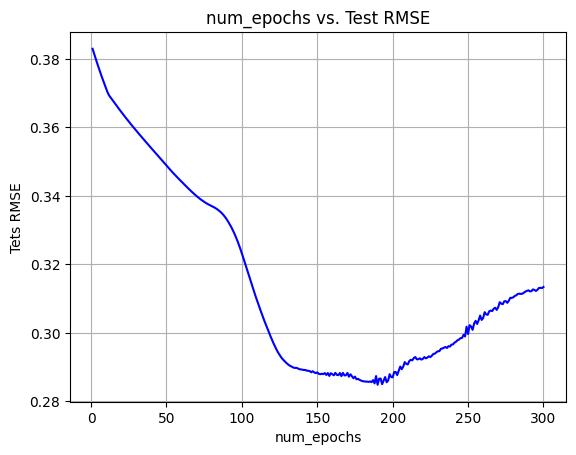

In [28]:
plt.plot(num_epochs_list, rmse_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test RMSE')
plt.xlabel('num_epochs')
plt.ylabel('Tets RMSE') 
plt.grid(True)
plt.show() 

In [29]:
min_rmse = min(rmse_list)
corresponding_r2_score = r2_scores_list[rmse_list.index(min_rmse)]
corresponding_num_epochs = num_epochs_list[rmse_list.index(min_rmse)]

print(f'Min RMSE score: {min_rmse}')
print(f'Corresponding R^2 SCore: {corresponding_r2_score}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Min RMSE score: 0.2848615667519758
Corresponding R^2 SCore: 0.2876154151963989
Corresponding num_epochs: 190


#### Test R^2 Score vs. num_epochs

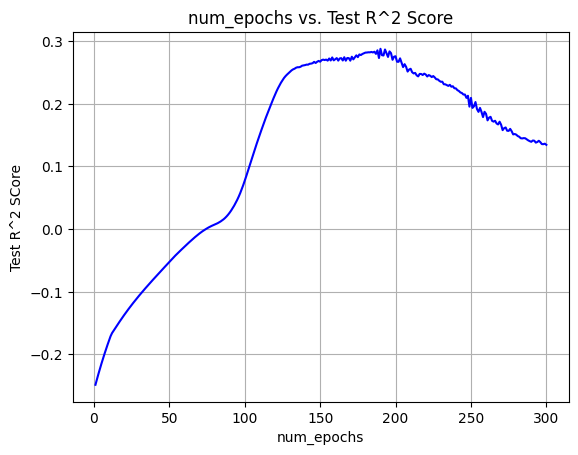

In [30]:
plt.plot(num_epochs_list, r2_scores_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test R^2 Score')
plt.xlabel('num_epochs')
plt.ylabel('Test R^2 SCore') 
plt.grid(True)
plt.show() 

In [31]:
max_r2_score = max(r2_scores_list)
corresponding_rmse = rmse_list[r2_scores_list.index(max_r2_score)]
corresponding_num_epochs = num_epochs_list[r2_scores_list.index(max_r2_score)]

print(f'Max R^2 score: {max_r2_score}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.2876154151963989
Corresponding RMSE: 0.2848615667519758
Corresponding num_epochs: 190


#### Test Adjusted R^2 Score (Valence) vs. num_epochs

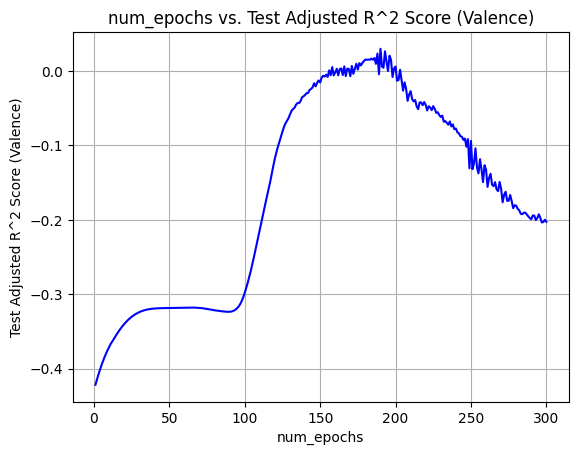

In [32]:
plt.plot(num_epochs_list, adjusted_r2_scores_valence_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test Adjusted R^2 Score (Valence)')
plt.xlabel('num_epochs')
plt.ylabel('Test Adjusted R^2 Score (Valence)') 
plt.grid(True)
plt.show() 

In [33]:
max_r2_score_valence = max(adjusted_r2_scores_valence_list)
corresponding_rmse = rmse_list[adjusted_r2_scores_valence_list.index(max_r2_score_valence)]
corresponding_num_epochs = num_epochs_list[adjusted_r2_scores_valence_list.index(max_r2_score_valence)]

print(f'Max R^2 score: {max_r2_score_valence}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.02999269115053993
Corresponding RMSE: 0.2848615667519758
Corresponding num_epochs: 190


#### Test Adjusted R^2 Score (Arousal) vs. num_epochs

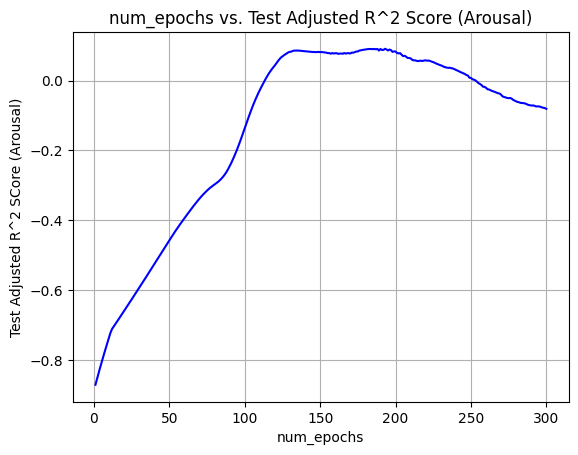

In [34]:
plt.plot(num_epochs_list, adjusted_r2_scores_arousal_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test Adjusted R^2 Score (Arousal)')
plt.xlabel('num_epochs')
plt.ylabel('Test Adjusted R^2 SCore (Arousal)') 
plt.grid(True)
plt.show() 

In [35]:
max_r2_score_arousal = max(adjusted_r2_scores_arousal_list)
corresponding_rmse = rmse_list[adjusted_r2_scores_arousal_list.index(max_r2_score_arousal)]
corresponding_num_epochs = num_epochs_list[adjusted_r2_scores_arousal_list.index(max_r2_score_arousal)]

print(f'Max R^2 score: {max_r2_score_arousal}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.09122232926948703
Corresponding RMSE: 0.2850349377472079
Corresponding num_epochs: 193
